# Calculating Copper - Jack Maughan

The ExploreSA Gawler Challenge was designed to find and apply new approaches to mineral exploration, using state geology and geophysics data.  The following notebook is a part of the series, __'Calculating Copper'__ and contains my thinking, processing and results for the challenge, with a idea of recreating a reproducible workflow for similar mineral exploration problems. 

![Title](https://docs.google.com/uc?export=download&id=1goFsreNqBipsuyFEOwi6cGgrpWwARCEt)

#### 1. Geology Forever - Background Information
### *2. Hair and Makeup - Target Variable and Features*
#### 3. Suit up - Compiling Dataframe and Feature Statistics
#### 4. My Friend Robot - Machine Learning Model Creation
#### 5. Gold Rush - Model Validation and Results
#### 6. Extra Extra - Unsupervised Learning and CoDa on Soil Geochemistry

# Hair and Makeup

From the __Geology Forever__ section, we figured out that we wanted to setup a supervised binary classification problem using drill hole data as the target variable and features containing various regional geophysical and geological data. In this notebook we look at engineering both the target variable and the features from the available datasets.

## Target Variable - Areas of Interest

Firstly we'll look at the target variable, which in this case we'll define as an 'Area of Interest' (AOI). The 'Areas' in the AOI feature are 250mx250m squares accross the Gawler Craton study area, assigned the values of 0 for barren areas, 1 for mineralised areas and -1 for the remaining 'unknown' areas. For an area to be considered as either barren or mineralised, the following criteria must be met; 

- The area must contain a drillhole assay sample of either elevated or insignificant base metal values (we'll come back to this)
- Samples are only included if they are not situated within the cover sequences and at a minimum of 100m depth
- Sample assay lengths must be greater than 1m and less than 10m

Firstly however, there needs to be some significant cleaning done on the geochemistry data. The original data files for the target variable come from __'The SARIG Data Package: Drilling, surface sample and observations'__ and have been cleaned using Caldera Analytics [data cleaning entry](https://github.com/mrodda117/CalderaPublic/blob/master/SARIG%20Geochemistry%20Data%20Entry%20Errors.ipynb) with some slight changes I have added. From here, the data is further cleaned to suit the specific needs of this problem, such as focusing on base metals and desurveying drill holes. 


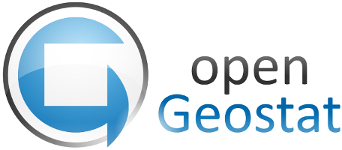

In [1]:
#Importing neccesary python packages
import pandas as pd
import numpy as np
import plotly.express as px
import pygslib

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
#Load in the assay data from Caldera Analytics notebook
df = pd.read_csv('Assays.csv')

In [3]:
df

,sample_id,ele,result,old_unit,method,fixed_result,isUDL,isNEG,isINT
0,458873_SA,Fe,82000.000000,%,AAS2,NaN,NaN,NaN,NaN
1,458873_SA,Mn,670.000000,ppm,AAS2,NaN,NaN,NaN,NaN
2,458873_SA,Cr,4.000000,ppm,AAS2,NaN,1.0,NaN,NaN
3,458873_SA,Ti,9500.000000,%,COL,NaN,NaN,NaN,NaN
4,458873_SA,Cu,200.000000,ppm,AAS1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
21030710,2978525_SA,Tm,3.090000,ppm,FB6/MS,NaN,NaN,NaN,NaN
21030711,2978525_SA,U,817.757802,ppm,FB6/MS,NaN,NaN,NaN,NaN
21030712,2978525_SA,W,124.000000,ppm,FB6/MS,NaN,NaN,NaN,NaN
21030713,2978525_SA,Y,199.400000,ppm,FB6/MS,NaN,NaN,NaN,NaN


Here we can see that there are 21,030,715 element assays for various samples in the dataset. At this stage we want to do a few things;

- Remove any 'unfixable' values from the Caldera Analytics cleaned data
- Address our negative and below detection limit (BDL or UDL) data
- Remove the '_SA' string from the sample id

Firstly we'll look at the unfixable data. In the Caldera Analytics cleaning notebook, any data point that was deemed incorrect and had data that was not fixable via manually assessing previous exploration reports was assigned a value of -777. In the next cell we will see how many of these data points there are.

In [4]:
#Viewing how many below detection limit values are fixable
df['isUDL'].value_counts()

 1.0      2715708
-777.0       4444
Name: isUDL, dtype: int64

We can see that there are 4,444 data points that are not fixable. We can remove these from our dataset. 

In [5]:
#Removing any unfixable values
df = df[df['isUDL'] != -777]

Next we want to deal with our 'below detection limit' values. Instead of removing the below detection limit data, we will keep it in our dataset in case we wish to do some compositional data analysis further down the track. To keep these below detection limits relevant we will impute them with a value less than that limit. A figure from the study of [Dmitrijeva (2020)](https://www.researchgate.net/publication/338500936_Multivariate_Statistical_Analysis_of_Trace_Elements_in_Pyrite_Prediction_Bias_and_Artefacts_in_Defining_Mineral_Signatures) illustrates the effect of using various imputed values for the BDL value. 

![Title](https://docs.google.com/uc?export=download&id=14gFhpW-nrHKc1M97Q3mgGSv-4zf91Y8_)

___Quantile-quantile plots of Sn and bivariate plots of log-transformed Sn versus Ti in ppm from the N = 1501 dataset illustrating the effect of (a) taking absolute values of the detection limit, (b) division of a detection limit value by two, (c) fixed value imputation, e.g., median (calculated from the imputed dataset) and (d) multiplicative lognormal replacement. Note the similarity between b and d and the narrower range of imputed Sn values for d. Note that fixed value imputation results in asymmetric Sn distribution.___

As our dataset is so large and contains a large variety of assay methods, we will go with the method of imputing half the below detection limit value, which appears to give similar results to the more mathematically heavy multiplicative lognormal replacement method. Prior to editing the detection limit values, we can overwrite the results column with the cleaned 'fixed results' column from the Caldera Analytics cleaning.

In [6]:
#If fixed result exists, overwrite the results column
df.loc[df['fixed_result'].notna(), 'result'] = df['fixed_result']

Next, we've also got some values that were negative in the original geochemistry data that need to be amended. 

In [7]:
#Viewing the negative values
df[df['isNEG']==1].sort_values(by='result')

,sample_id,ele,result,old_unit,method,fixed_result,isUDL,isNEG,isINT
326978,408157_SA,Sn,0.000000,g/T,UKN,NaN,NaN,1.0,1.0
325739,408033_SA,W,0.000000,g/T,UKN,NaN,NaN,1.0,1.0
323014,637941_SA,Te,0.300000,g/T,UKN,NaN,NaN,1.0,1.0
340899,1478298_SA,Nb,0.699056,g/T,XRF,NaN,NaN,1.0,1.0
325575,637681_SA,Nb,0.699056,g/T,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...
341055,1478322_SA,Te,62.000000,g/T,XRF,NaN,NaN,1.0,1.0
321873,637788_SA,Te,65.000000,g/T,UKN,NaN,NaN,1.0,1.0
327624,407995_SA,Te,70.000000,g/T,UKN,NaN,NaN,1.0,1.0
321669,637769_SA,Ba,117.000000,g/T,UKN,NaN,NaN,1.0,1.0


We can see that there are 1994 values that were negative in the dataset. It is likely that some of these values are the negative representation of the BDL value, but as we have values up to -250ppm (Cobalt) and there are only 1,994 samples it is safer to remove these negative values.

In [8]:
#Removing any negative values
df = df[df['isNEG'] != 1]

In the next cell we'll impute the below detection limit values with half of the detection limit.

In [9]:
#Halving below detection limit values
df.loc[df['isUDL'] == 1, 'result'] = df['result']/2

Now we will remove any results where the value is equal to 0ppm as we are not sure whether this value is below detection limit or whether it was even assayed at all. We'll also fix the '_SA' string issue.

In [10]:
#removing any assays where the results are equal to zero to remove uncertainty
df = df[df['result']!=0]

#Fixing strings on samples
df['sample_id'] = df['sample_id'].str.replace('_SA', '')

Next we will pivot the table to give each element its own column and in turn making it more compatible with QGIS.

In [11]:
#Pivoting table and renaming axis
df_p = pd.pivot_table(df, index=['sample_id', 'method'], columns='ele', values='result')
df_p = df_p.rename_axis(None, axis=1).reset_index()

In [12]:
df_p

,sample_id,method,Ag,Al,As,Au,B,Ba,Be,Bi,Ca,Cd,Ce,Co,Cr,Cs,Cu,Dy,Er,Eu,F,Fe,Ga,Gd,Ge,Hf,Hg,Ho,In,Ir,K,La,Li,Lu,Mg,Mn,Mo,Na,Nb,Nd,Ni,Os,P,Pb,Pd,Pr,Pt,Rb,Re,Rh,Ru,S,Sb,Sc,Se,Si,Sm,Sn,Sr,Ta,Tb,Te,Th,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr
0,10013,ICP,1.0,NaN,13.0,NaN,NaN,470.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,8.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10014,ICP,1.0,NaN,15.0,NaN,NaN,500.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10015,ICP,0.5,NaN,11.0,NaN,NaN,480.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10016,ICP,1.0,NaN,23.0,NaN,NaN,580.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10017,ICP,1.0,NaN,25.0,NaN,NaN,600.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820539,9995,AES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,6.0,NaN,5.0,NaN,NaN,NaN,NaN
2820540,9996,AES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,NaN,NaN
2820541,9997,AES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,NaN,NaN
2820542,9998,AES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN


Above we can see the pivoted assay table containing the sample ID and assay method. To move forward, we need to add the collar and sample data. In the next few steps we bring in the sample and collar data and merge them into a single dataframe. Note that the collars file only contains drill holes from within the study area, therefore excluding a large portion of the above assay table. It also contains the X and Y co-ordinates for each collar (GDA2020 Zone 53 datum) and the elevation, which will be later used for desurveying. This part of the cleaning was completed in __QGIS__.

In [13]:
#loading in the sample and collar data
df_s = pd.read_csv('Sample_Info.csv')
df_l = pd.read_csv('Collars.csv')

In [14]:
#Removing string 
df_s['sample_id'] = df_s['sample_id'].str.replace('_SA', '')
df_s['collar_id'] = df_s['collar_id'].str.replace('_SA', '')
df_l['collar_id'] = df_l['collar_id'].str.replace('_SA', '')

In [15]:
#Merging sample data
tmp = df_l.merge(df_s,
                 on = 'collar_id',
                 validate = '1:m')

In [16]:
#Merging collar data
df = tmp.merge(df_p,
                 on = 'sample_id',
                 validate = '1:m')

In [17]:
df

,collar_id,collar_nam,max_depth,date_drill,lon,lat,dip,azi,reference,xcoord,ycoord,DEM,sample_id,sample_source,from,to,method,Ag,Al,As,Au,B,Ba,Be,Bi,Ca,Cd,Ce,Co,Cr,Cs,Cu,Dy,Er,Eu,F,Fe,Ga,Gd,Ge,Hf,Hg,Ho,In,Ir,K,La,Li,Lu,Mg,Mn,Mo,Na,Nb,Nd,Ni,Os,P,Pb,Pd,Pr,Pt,Rb,Re,Rh,Ru,S,Sb,Sc,Se,Si,Sm,Sn,Sr,Ta,Tb,Te,Th,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr
0,436,NULLARBOR PLAINS 6,304.80,10/09/1899,131.193825,-31.149046,-90.0,NaN,ENV 06488,137080.83819,6.547639e+06,69.562889,63504,Drill cuttings,295.66,299.92,AAS,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2400.0,NaN
1,577,NULLARBOR PLAINS 7,162.15,31/12/1900,131.597958,-31.047286,-90.0,NaN,ENV 06488,175290.92394,6.560182e+06,79.739357,2132968,Drill cuttings,114.00,150.88,ME-4ACD81,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,14.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,0.5,NaN,NaN,NaN,39.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,NaN
2,577,NULLARBOR PLAINS 7,162.15,31/12/1900,131.597958,-31.047286,-90.0,NaN,ENV 06488,175290.92394,6.560182e+06,79.739357,2132968,Drill cuttings,114.00,150.88,ME-ICP06,NaN,64038.105319,NaN,NaN,NaN,806.090461,NaN,NaN,16875.746714,NaN,NaN,NaN,87.60403,NaN,NaN,NaN,NaN,NaN,NaN,43995.243757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19591.565665,NaN,NaN,NaN,13267.398384,542.131351,NaN,23145.400593,NaN,NaN,NaN,NaN,567.28923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329562.453254,NaN,NaN,338.237781,NaN,NaN,NaN,NaN,3357.112883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,577,NULLARBOR PLAINS 7,162.15,31/12/1900,131.597958,-31.047286,-90.0,NaN,ENV 06488,175290.92394,6.560182e+06,79.739357,2132968,Drill cuttings,114.00,150.88,ME-MS42,NaN,NaN,4.8,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021,NaN,0.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006,NaN,NaN,NaN,0.33,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,577,NULLARBOR PLAINS 7,162.15,31/12/1900,131.597958,-31.047286,-90.0,NaN,ENV 06488,175290.92394,6.560182e+06,79.739357,2132968,Drill cuttings,114.00,150.88,ME-MS81,NaN,NaN,NaN,NaN,NaN,763.000000,NaN,NaN,NaN,NaN,88.2,NaN,90.00000,1.97,NaN,2.05,1.11,1.15,NaN,NaN,15.8,3.09,2.5,3.4,NaN,0.4,NaN,NaN,NaN,50.3,NaN,0.15,NaN,NaN,NaN,NaN,9.4,30.9,NaN,NaN,NaN,NaN,NaN,9.25,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.57,2.0,341.000000,0.6,0.42,NaN,3.86,NaN,0.25,0.17,1.100000,62.0,1.0,10.4,1.07,NaN,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555998,333102,RU41-11783,280.00,26/10/2018,136.897367,-30.447016,-22.0,197.87,NaN,682187.22501,6.630151e+06,106.889030,2978525,Drill core,278.00,280.00,4AB/OE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN
1555999,333102,RU41-11783,280.00,26/10/2018,136.897367,-30.447016,-22.0,197.87,NaN,682187.22501,6.630151e+06,106.889030,2978525,Drill core,278.00,280.00,CSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have a dataframe that contains the sample ID's for each assay and the collar information for the drillhole they were sampled from. For desurveying, we need to ensure that the collar 'drill to' depth is greater than the 'sample to' depth for each assay (can't sample drill core that was never drilled). To do this we create a new column where if the maximum depth is shallower than expected we just make it equal to the deepest sample depth.

In [18]:
#Fixing Max Depths
df['sampletomax'] = df.groupby(['collar_nam'])['to'].transform(max)
df.loc[df['max_depth'] >= df['sampletomax'], 'true_max'] = df['max_depth']
df.loc[df['max_depth'] < df['sampletomax'], 'true_max'] = df['sampletomax']

Next we want to fix up unknown dip and azimuth data. For desurveying it would be really nice to have data for every hole but for the unknown surveys we will just assume the holes were vertical. We will also assume the dip data contains a mix of interior and exterior inclination angles, and that any inclination less than 40 degrees is the opposite dip angle (ie. a dip of 15 degrees inclination is actually 75 degrees).

In [19]:
#Fixing dip and azi
df['dip'] = df['dip'].fillna(-90.0)
df['azi'] = df['azi'].fillna(-0)

#Setting all data to negative dip
df['dip'] = -df['dip'].abs()

In [20]:
#Assume all inclination below 40 are incorrect and fix
df.loc[df['dip']<=(-40), 'true_dip'] = df['dip']
df.loc[df['dip']>(-40), 'true_dip'] = -(df['dip']+90) 

There are also some interval data issues, where we have data with no 'from' values and/or no 'to' values. Here we will remove all unknown 'from' values, assume all assays with unknown 'to' values have 1m sample lengths and remove all 'to' = 0 assays.

In [21]:
#Remove all unknown values from 'from'
df=df[~df['from'].isnull()]

#assume all unknown 'to' samples are 1m length
df['to'] = df['to'].fillna(df['from']+1)

#Remove all entries where the to value is 0
df = df[df['to']!=0]

For the next step we want to create an interval length column and see how the sample lengths for each assay compare. 

In [22]:
#Creating an interval column
df['Interval'] = df['to'] - df['from']

#Fixing unknown sample sources
df['sample_source'] = df['sample_source'].fillna('unkn')

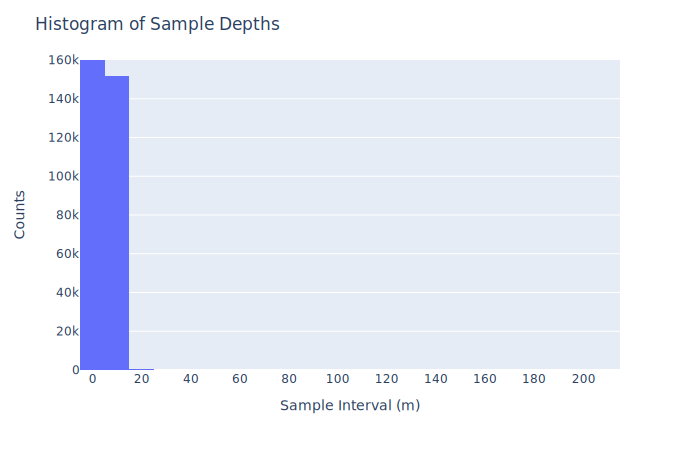

In [23]:
#Plotting the sample interval lengths histogram
fig = px.histogram(df, x="Interval", nbins=40)

fig.update_layout(xaxis = dict(title='Sample Interval (m)', tickmode = 'linear', tick0 = 0, dtick = 20), 
                  yaxis = dict(title='Counts'),
                  title = "Histogram of Sample Depths",
                  showlegend = False,
                  barmode='stack')

fig.update_yaxes(range=[0, 160000])

fig.show()

We can see that there is some dirty data here with one of the assays having a sample length of over 200m. In the next few steps we'll look at some of the dirty interval data and fix them accordingly.

In [24]:
#Holes that had drill intervals over 20m
df[df['Interval']>20]['collar_nam'].value_counts()

RD503                 8
CSD 1                 7
IHAD6                 7
98ACD242              6
NULLARBOR PLAINS 7    5
SD-01                 4
WPDD2                 3
TA05R011              3
RRP6/2                2
RRP7/8                2
MUL 001               2
RRP7/6                2
RW-27                 2
RL 1                  2
2000CADI7             2
CED 19                2
RRP7/3                2
RRP7/7                2
RRP6/9                2
MUL 063               2
EC 40                 1
KENELLA 4A            1
PY 1                  1
QR266                 1
PK DD 2               1
HNWPR55               1
CR92 20               1
EC 21                 1
PK DD 3               1
CR92 19               1
Name: collar_nam, dtype: int64

In [25]:
#CHANGING CELL
#Checking through for each one
df[(df['collar_nam']=='RL 1') & (df['Interval']>10)]

,collar_id,collar_nam,max_depth,date_drill,lon,lat,dip,azi,reference,xcoord,ycoord,DEM,sample_id,sample_source,from,to,method,Ag,Al,As,Au,B,Ba,Be,Bi,Ca,Cd,Ce,Co,Cr,Cs,Cu,Dy,Er,Eu,F,Fe,Ga,Gd,Ge,Hf,Hg,Ho,In,Ir,K,La,Li,Lu,Mg,Mn,Mo,Na,Nb,Nd,Ni,Os,P,Pb,Pd,Pr,Pt,Rb,Re,Rh,Ru,S,Sb,Sc,Se,Si,Sm,Sn,Sr,Ta,Tb,Te,Th,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr,sampletomax,true_max,true_dip,Interval
7762,16695,RL 1,674.6,27/07/1982,136.067819,-30.321047,-90.0,0.0,ENV 04113,602658.47114,6.645156e+06,127.108093,63432,Drill core,250.0,300.0,AAS,0.5,NaN,NaN,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,668.9,674.6,-90.0,50.0
7763,16695,RL 1,674.6,27/07/1982,136.067819,-30.321047,-90.0,0.0,ENV 04113,602658.47114,6.645156e+06,127.108093,63432,Drill core,250.0,300.0,XRF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,668.9,674.6,-90.0,50.0


In [26]:
#Fix holes in reference to SARIG database
#Fixing RD503
df.loc[list(range(47401, 47409)), 'from'] = 642

#Fixing CSD 1
df.loc[list(range(8512, 8519)), 'to'] = 870.9

#Fixing PH-DD05MS004
df.loc[list(range(436474, 436477)), 'to'] = 662

#Fixing 98ACD242
df.loc[[80030, 80031], 'from'] = 181
df.loc[[80442, 80443], 'to'] = 367
df.loc[[80440, 80441], 'to'] = 369

#Fixing IHAD3
df.loc[[663622, 663623, 663624], 'from'] = 368

#Fixing WPDD2
df.loc[[881022, 881023, 881024], 'to'] = 769.2

#Fixing PY 1
df.loc[[12050], 'to'] = 1010

#Fixing 2000CADI7
df.loc[[64525, 64526], 'to'] = 230

#Fixing HNWPR55
df.loc[[1156448], 'from'] = 110

#Dropping RL 1
df = df.drop([7761, 7762])

In [27]:
#Updating the interval column
df['Interval'] = df['to'] - df['from']

Now that some of the dirty data has been fixed we can condense our dataset a bit more by removing any sample with sample length less than 1m and greater than 10m. This will ensure we are not including smaller samples that have been cherry picked (containing high copper assays over small veinlets for example) or large samples that are too diluted. We will also remove any samples that have depths less than 100m, so that we reduce the risk of getting samples within the cover sequences. 

In [28]:
#Select only samples with interval length between 1 and 10
df = df[(df['Interval']>=1)&(df['Interval']<=10)]

#Select only samples that are below 100m
df = df[df['to']>=100]

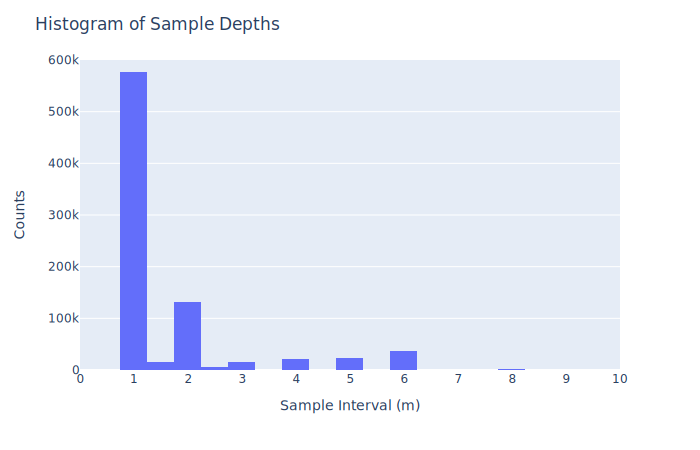

In [29]:
#Plotting the sample interval lengths histogram
fig = px.histogram(df, x="Interval", nbins=40)

fig.update_layout(xaxis = dict(title='Sample Interval (m)', tickmode = 'linear', tick0 = 0, dtick = 1), 
                  yaxis = dict(title='Counts'),
                  title = "Histogram of Sample Depths",
                  showlegend = False,
                  barmode='stack')

fig.update_xaxes(range=[0, 10])
fig.update_yaxes(range=[0, 600000])

fig.show()

In [30]:
#Viewing the different sample types
df['sample_source'].value_counts()

Drill core                                                      374490
Sawn half drill core                                            232481
Drill cuttings                                                  154378
Drilled interval rock sample, type unspecified                   44228
Sawn quarter drill core                                          16604
Core sludge                                                       4167
A full face slice of core                                         2111
Pulp / powdered rock of known origin, typically a lab return      1208
Aircore: consolidated sample from aircore drilling method          106
unkn                                                                86
Duplicate: a split from an existing sample.                         18
Name: sample_source, dtype: int64

We can see that the majority of our samples have lengths of 1m and were sample from drill core or drill cuttings. Now that we have our dataset cleaned to the level we want, we can look at desurveying the drillholes to get a more accurate representation of where the sample is located with respect to its collar. To do this we set up the collar, survey and assay data into separate tables and use python package [PySGLIB](https://opengeostat.github.io/pygslib/).

### Collar

In [31]:
#Subsetting Collar Data
collar = df[['collar_nam', 'xcoord', 'ycoord', 'DEM']]
collar = collar.rename(columns={'collar_nam':'BHID', 'xcoord':'XCOLLAR', 'ycoord':'YCOLLAR', 'DEM':'ZCOLLAR'})
collar = collar.drop_duplicates('BHID')

In [32]:
collar

,BHID,XCOLLAR,YCOLLAR,ZCOLLAR
0,NULLARBOR PLAINS 6,137080.83819,6.547639e+06,69.562889
22,TW 1,208744.37599,6.556477e+06,67.097267
49,TW 4,208208.60504,6.558013e+06,71.534447
89,TW 5,207128.93953,6.557195e+06,65.308632
109,TW 6,206285.49456,6.557976e+06,66.677780
...,...,...,...,...
1553225,RD38,679774.52810,6.630960e+06,107.408196
1553903,RD80,683245.23349,6.630092e+06,108.263771
1554755,RU41-11782,682187.33232,6.630151e+06,106.889030
1555055,RU41-11782W1,682187.33232,6.630151e+06,106.889030


### Survey

In [33]:
#Subsetting Survey Data
survey = df[['collar_nam', 'true_max', 'true_dip', 'azi']]
survey.columns = ['BHID', 'AT', 'DIP', 'AZ']
survey = survey.drop_duplicates()

In [34]:
survey

,BHID,AT,DIP,AZ
0,NULLARBOR PLAINS 6,304.8,-90.0,0.00
22,TW 1,200.0,-90.0,0.00
49,TW 4,192.0,-90.0,0.00
89,TW 5,117.0,-90.0,0.00
109,TW 6,120.1,-90.0,0.00
...,...,...,...,...
1553225,RD38,1001.1,-90.0,347.47
1553903,RD80,981.0,-90.0,347.47
1554755,RU41-11782,219.7,-76.9,198.27
1555055,RU41-11782W1,236.2,-76.9,198.27


For the survey data, PySGLIB requires information for both the start and end of the hole. As we only have EOH survey data we need to create data at 0m. To do this we just duplicate all dip and azimuth data but set the depth to 0m, which maintains the same information from surface to EOH.

In [35]:
#Creating a repeated dataframe and setting columns
survey2 = pd.DataFrame(np.repeat(survey.values, 2, axis=0))
survey2.columns = survey.columns

#Accessing every second row, setting the depth to 0m (surface) and concatenating with original survey
survey2 = survey2.iloc[::2, :]
survey2['AT'] = 0
survey = pd.concat([survey, survey2])

#Removing any duplicates
survey['AT'] = survey['AT'].fillna(0)
survey = survey.drop_duplicates()

There is some dirty data resulting from this step, which is cleaned up in the next few cells.

In [36]:
#Showing where duplicated values are
survey[survey.duplicated(['BHID', 'AT'], keep=False)].sort_values('BHID')

,BHID,AT,DIP,AZ
16752,TD 1,498.0,-90,0
154235,TD 1,498.0,-60,100
196,TD 1,0.0,-90,0
1738,TD 1,0.0,-60,100


In [38]:
#Removing them
survey = survey.drop([16752, 196])

In [39]:
#Sorting datatable
survey = survey.sort_values(['BHID', 'AT'])
survey[survey['AT']==0]

,BHID,AT,DIP,AZ
2216,00CHWB003,0.0,-90,0
2218,01CDDH0020,0.0,-60,117
2220,01CDDH0021,0.0,-60,117
2222,01CDDH0022,0.0,-60,117
2224,01CDDH0023,0.0,-58,115
...,...,...,...,...
4092,YSAC015,0.0,-90,0
4094,YSAC021,0.0,-90,0
4096,YSAC022,0.0,-90,0
4098,YSAC024,0.0,-90,0


### Assay

In [40]:
#Subsetting Assay Data
assay = df.drop(['collar_id', 'max_depth', 'lon', 'lat', 'dip', 'sampletomax'], axis=1)
assay = assay.rename(columns={'collar_nam':'BHID', 'from':'FROM', 'to':'TO'})

In [41]:
assay

,BHID,date_drill,azi,reference,xcoord,ycoord,DEM,sample_id,sample_source,FROM,TO,method,Ag,Al,As,Au,B,Ba,Be,Bi,Ca,Cd,Ce,Co,Cr,Cs,Cu,Dy,Er,Eu,F,Fe,Ga,Gd,Ge,Hf,Hg,Ho,In,Ir,K,La,Li,Lu,Mg,Mn,Mo,Na,Nb,Nd,Ni,Os,P,Pb,Pd,Pr,Pt,Rb,Re,Rh,Ru,S,Sb,Sc,Se,Si,Sm,Sn,Sr,Ta,Tb,Te,Th,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr,true_max,true_dip,Interval
0,NULLARBOR PLAINS 6,10/09/1899,0.00,ENV 06488,137080.83819,6.547639e+06,69.562889,63504,Drill cuttings,295.66,299.92,AAS,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2400.0,NaN,304.8,-90.0,4.26
22,TW 1,31/08/1980,0.00,ENV 03530,208744.37599,6.556477e+06,67.097267,63535,Drill cuttings,101.00,103.00,AAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,200.0,-90.0,2.00
23,TW 1,31/08/1980,0.00,ENV 03530,208744.37599,6.556477e+06,67.097267,63536,Drill cuttings,105.00,107.00,AAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,200.0,-90.0,2.00
24,TW 1,31/08/1980,0.00,ENV 03530,208744.37599,6.556477e+06,67.097267,63537,Drill cuttings,109.00,111.00,AAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,200.0,-90.0,2.00
25,TW 1,31/08/1980,0.00,ENV 03530,208744.37599,6.556477e+06,67.097267,63538,Drill cuttings,113.00,115.00,AAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,200.0,-90.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555998,RU41-11783,26/10/2018,197.87,NaN,682187.22501,6.630151e+06,106.889030,2978525,Drill core,278.00,280.00,4AB/OE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,280.0,-68.0,2.00
1555999,RU41-11783,26/10/2018,197.87,NaN,682187.22501,6.630151e+06,106.889030,2978525,Drill core,278.00,280.00,CSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.0,-68.0,2.00
1556000,RU41-11783,26/10/2018,197.87,NaN,682187.22501,6.630151e+06,106.889030,2978525,Drill core,278.00,280.00,FA25/OE,NaN,NaN,NaN,0.698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.0

### Desurveying

Now that we have the collar, survey and assay data tables we can desurvey the drillholes and get a more accurate location of each sample. This is especially important in this kind of problem. As we are trying to recreate a 3 dimensional geological system in 2 dimensions, we want the geophysics to line up with the sample data the best we possibly can. The following image gives a visual representation of why this is important, where the underlying magnetic response at the collar locations are vastly different from the response at the sample locations.

![Title](https://docs.google.com/uc?export=download&id=1QKnB7dAKwH5ZpYrzrzIHQFCHJK-zwaot)

Using PySGLIB we'll load in the tables and desurvey the data. __(NOTE: PySGLIB has some issues running in Jupyter, I have provided the desurveyed data in the following few cells__

In [42]:
#Loading in the collar, survey and assay data
mydholedb=pygslib.drillhole.Drillhole(collar=collar, survey=survey)
mydholedb.addtable(assay, 'assay', overwrite = False)

In [43]:
#Validating drillholes
mydholedb.validate()

In [44]:
#Validating the assay table
mydholedb.desurvey('assay', warns=False, endpoints=True)

In [45]:
ddf = pd.DataFrame(mydholedb.table["assay"])

In [47]:
####Reading in CSV file incase PYSGLIB package does not work 

##ddf = pd.read_csv('PYSGLIB RESULT.csv')
##ddf

,Unnamed: 0,BHID,date_drill,azi,reference,xcoord,ycoord,DEM,sample_id,sample_source,FROM,TO,method,Ag,Al,As,Au,B,Ba,Be,Bi,Ca,Cd,Ce,Co,Cr,Cs,Cu,Dy,Er,Eu,F,Fe,Ga,Gd,Ge,Hf,Hg,Ho,In,Ir,K,La,Li,Lu,Mg,Mn,Mo,Na,Nb,Nd,Ni,Os,P,Pb,Pd,Pr,Pt,Rb,Re,Rh,Ru,S,Sb,Sc,Se,Si,Sm,Sn,Sr,Ta,Tb,Te,Th,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr,true_max,true_dip,Interval,azmm,dipm,xm,ym,zm,azmb,dipb,xb,yb,zb,azme,dipe,xe,ye,ze
0,0,00CHWB003,14/12/2000,0.0,ENV 09006,360998.81012,6.694173e+06,182.485229,1359262,"Drilled interval rock sample, type unspecified",96.0,100.0,B/ETA,NaN,NaN,NaN,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,-90.0,4.0,180.0,-90.0,360998.81012,6.694173e+06,280.485229,180.0,-90.0,360998.81012,6.694173e+06,278.485229,180.0,-90.0,360998.81012,6.694173e+06,282.485229
1,1,00CHWB003,14/12/2000,0.0,ENV 09006,360998.81012,6.694173e+06,182.485229,1359263,"Drilled interval rock sample, type unspecified",100.0,104.0,B/ETA,NaN,NaN,NaN,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,-90.0,4.0,180.0,-90.0,360998.81012,6.694173e+06,284.485229,180.0,-90.0,360998.81012,6.694173e+06,282.485229,180.0,-90.0,360998.81012,6.694173e+06,286.485229
2,2,00CHWB003,14/12/2000,0.0,ENV 09006,360998.81012,6.694173e+06,182.485229,1359264,"Drilled interval rock sample, type unspecified",104.0,108.0,B/ETA,NaN,NaN,NaN,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,-90.0,4.0,180.0,-90.0,360998.81012,6.694173e+06,288.485229,180.0,-90.0,360998.81012,6.694173e+06,286.485229,180.0,-90.0,360998.81012,6.694173e+06,290.485229
3,3,00CHWB003,14/12/2000,0.0,ENV 09006,360998.81012,6.694173e+06,182.485229,1359265,"Drilled interval rock sample, type unspecified",108.0,112.0,B/ETA,NaN,NaN,NaN,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,-90.0,4.0,180.0,-90.0,360998.81012,6.694173e+06,292.485229,180.0,-90.0,360998.81012,6.694173e+06,290.485229,180.0,-90.0,360998.81012,6.694173e+06,294.485229
4,4,00CHWB003,14/12/2000,0.0,ENV 09006,360998.81012,6.694173e+06,182.485229,1359266,"Drilled interval rock sample, type unspecified",112.0,116.0,B/ETA,NaN,NaN,NaN,0.0010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,-90.0,4.0,180.0,-90.0,360998.81012,6.694173e+06,296.485229,180.0,-90.0,360998.81012,6.694173e+06,294.485229,180.0,-90.0,360998.81012,6.694173e+06,298.485229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829872,829872,YSAC026,05/12/2008,0.0,ENV 10621,458587.70897,6.430818e+06,93.073540,1810968,Drill cuttings,96.0,100.0,B/ETA,NaN,NaN,NaN,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Here we can see the desurveyed data table with new columns reflecting the samples new eastings and northings data. Before we start using QGIS and plotting the samples we'll do a quick check of the actual assay data.

### Base Metal Data Check

Here we look at the highest values of gold, copper, lead and zinc to make sure they are legitamtate by cross referencing them to their exploration reports. Originally, silver was also included in this workflow, but due to the amount of high detection limits from various assays I found it best to exclude it from the target variable. 

#### Gold

In [48]:
#looking at the highest Au values
ddf[['BHID', 'date_drill', 'reference', 'method', 'sample_id', 'FROM', 'TO', 'Au']].sort_values('Au', ascending=False).head(500)

,BHID,date_drill,reference,method,sample_id,FROM,TO,Au
544144,LRC496,13/02/2005,ENV 09008,B/SAAS,703808,156.0,157.00,4999.500
506895,LRC105,16/05/1997,ENV 09008,P625,2852447,103.0,104.00,4999.500
498439,LRC012,11/11/1996,ENV 09008,P625,2843875,131.0,132.00,4999.500
509029,LRC123,25/05/1997,ENV 09008,P625,2854865,130.0,131.00,3888.500
508411,LRC117,26/05/1997,ENV 09008,P625,2854145,130.0,131.00,3888.500
...,...,...,...,...,...,...,...,...
10627,07CDDH0077W1,17/05/2007,ENV 11460,PAL,1735849,895.0,896.05,10.820
754460,THDD-056,31/08/2015,ENV 12300,Au-AA25,2799855,210.0,211.00,10.800
437839,DP010,03/11/2002,ENV 06960,FA1,2003601,516.0,517.00,10.774
407,01CDRC0202,27/01/2001,ENV 09006,FA50/AAS,1361501,124.0,125.00,10.740


In [49]:
#Fixing Au values
ddf.loc[(ddf['reference']=='ENV 06960')&(ddf['method']=='FA2'), 'Au'] = ddf['Au']/1000
ddf.loc[(ddf['reference']=='ENV 09008')&(ddf['method']=='B/AAS'), 'Au'] = ddf['Au']/1000

#### Copper

In [50]:
#looking at the highest Cu values
ddf[['BHID', 'date_drill', 'reference', 'sample_id', 'Cu']].sort_values('Cu', ascending=False).head(500)

,BHID,date_drill,reference,sample_id,Cu
782266,WRD29,30/06/2008,ENV 09288,2077720,176000.0
596513,PH06D221,08/02/2006,NaN,1986731,140000.0
596511,PH06D221,08/02/2006,NaN,1986730,140000.0
596481,PH06D221,08/02/2006,NaN,1986715,137000.0
596479,PH06D221,08/02/2006,NaN,1986714,137000.0
...,...,...,...,...,...
723442,RP034,26/07/2003,ENV 06960,1978391,56000.0
146189,CAR051W1,22/04/2007,ENV 09185,1874689,56000.0
604674,PH06D257,15/03/2006,NaN,1992417,55900.0
590770,PH06D210,17/01/2006,NaN,1982893,55900.0


#### Lead

In [51]:
#looking at the highest Pb values
ddf[['BHID', 'date_drill', 'reference', 'sample_id', 'Pb']].sort_values('Pb', ascending=False).head(500)

,BHID,date_drill,reference,sample_id,Pb
459452,GP002D,05/03/1996,NaN,1593295,76100.0
459455,GP002D,05/03/1996,NaN,1593296,63300.0
26223,2000CADI7,21/08/2000,ENV 09248,2011808,61632.0
802313,WRD34,04/10/2010,ENV 09288,2663701,46100.0
309022,DD10EPS006,22/08/2010,ENV 06960,2622229,44944.0
...,...,...,...,...,...
624555,RC06PD027,25/01/2006,NaN,1283388,2480.0
824976,WRD51,27/02/2012,ENV 09288,2124130,2470.0
458346,GHDD6,26/03/2008,ENV 11340,1931451,2462.0
360503,DD11HLH008,21/03/2011,ENV 06960,2626419,2460.0


#### Zinc

In [52]:
#looking at the highest Zn values
ddf[['BHID', 'date_drill', 'reference', 'sample_id', 'Zn']].sort_values('Zn', ascending=False).head(500)

,BHID,date_drill,reference,sample_id,Zn
606436,PH06D261,19/03/2006,NaN,1993463,106000.0
606438,PH06D261,19/03/2006,NaN,1993462,106000.0
606426,PH06D261,19/03/2006,NaN,1993456,103000.0
606424,PH06D261,19/03/2006,NaN,1993457,103000.0
606458,PH06D261,19/03/2006,NaN,1993475,101000.0
...,...,...,...,...,...
458183,GHDD6,26/03/2008,ENV 11340,1931405,4765.0
417186,DD12THM001,09/09/2012,ENV 06960,2656849,4756.0
458228,GHDD6,26/03/2008,ENV 11340,1931418,4727.0
456353,GHDD3,12/04/2007,ENV 11340,1932631,4723.0


In [53]:
#Fixing Zn Values
ddf.loc[ddf['BHID']=='HNWPR95A', 'Zn'] = ddf['Zn']/1000
ddf.loc[ddf['BHID']=='PH06D261', 'Zn'] = ddf['Zn']/1000

Now the base metal values have been cleaned we can save the dataframe as a csv file and open it in QGIS.

In [53]:
#Saving csv file
ddf.to_csv('Samples_Desurveyed.csv')

The first step once the data is in QGIS is to split the areas based on Au, Cu, Pb and Zn values. For each of the 4 base metals, 3 separate shapefiles were created named AOI, Meh and Null that reflected the 'level of interest' of each sample. The assay values for each respective level of interest can be seen in the following table.

![Title](https://docs.google.com/uc?export=download&id=1CthE-1t_aPy9foy0qkFJc4r5FaHmVmYg)

Next, each sample that was not located within the basement was removed. This was done by taking the __'Depth to Basement'__ drillhole dataset from SARIG and creating polygon contours from the __'Cover Thickness'__ column. If the sample had had a 'depth to' value that was shallower than the cover thickness it was flagged. From here we manually removed any samples, paying attention to whether the depths made sense with surrounding drillholes. Note that basement in this case is not just restricted to the crystalline basement, and includes any lithologies below the cover sequences.

![Title](https://docs.google.com/uc?export=download&id=1MZ2_LYSQ4zQ2GApSy9cKEPthmoP_Ufpz)

From here the AOI, Meh and Null shapefiles were concatenated and a 1000m buffer was given to the AOI points. Any sample from the Meh or Null datasets that fell within this 1000m buffer were removed. This was done to ensure there were no 'barren' assay samples within close proximity to a highly mineralised area (for example a barren sample located within a host rock above or below significant mineralisation). A 500m buffer was then placed around the Meh dataset and all Null points were removed. This was to ensure that all non-mineralised samples contained significantly low metal values.

![Title](https://docs.google.com/uc?export=download&id=1qniW6zujGl_AXBs2rhmaKpTqz0uu7iJq)

Once the samples within close proximity had been cleaned and have been removed according to their emplacement within the cover sequence the AOI and Null data tables were combined. This data set contains the binary target variable we will use in the machine learning stage going forward.

![Title](https://docs.google.com/uc?export=download&id=1X2D4n-qGq7_3UV_e-t4rAIXkSHe_XDzZ)

Before moving onto the feature set it's good to assess some of the issues that this target variable may contain.

##### Issues
- Dirty Data that may have gone unnoticed
- Combination of various sample types, various analysis methods and sample lengths
- Varying sample depths and the ambiguity in cover thickness in some areas
- Mineralised areas have at least one elevated base metal and barren areas may have not have assay data for one or more of the 4 base metal
- Elevated base metals may not be directly related to hydrothermal/magmatic activity or structural traps (remobilised gold for example)
- Survey dataset was incomplete and may cause misleading geophysical/geological relationships
- Locally clustered samples may skew data as they share a very similar relationship to the features
- We lose confidence in our metal source without going deeper into deposit type

## Features

For our problem, we want to have features that are numerically represented accross the whole study area. When trying to use geology this can become difficult as it is not a very 'exact' science, with a lot of room for interpretability, especially when we are looking at such a large scale problem. From the data available we can engineer some features and split them into 4 different groups; geology, magnetics, gravity and induced polarisation.

### Geology

From the available geology data we can look at using the fault and Archaean contact data to create distance rasters across the study area. The faults and contacts can be thought of as potential structural traps in our mineral systems approach, which could be related to the mineralisation in the target variable. We will create two geological features from the SARIG data; Distance to Faults and Distance to Archaean Contact. The distance to faults data will contain information from both the Archaean and Mesoproterozoic datasets whereas the lithological contact data is sourced just from the Archaean Polygon dataset. We will also perform a log transform on these features due to the log distribution of the data.

![Title](https://docs.google.com/uc?export=download&id=1oXAwL0MV9DiuZQZPjITTueD5w6UkblG8)

##### Issues
- There's high potential that not all faults and contacts are mapped and recorded
- Faults and contacts have been interpreted by geophysics or other methods and may have low confidence levels
- These structures are rarely vertical, meaning the distance values vary with depth

### Magnetics

From both the GCAS and other SARIG data we have access to some incredible magnetic imagery over the craton. After having a look through what's available we have chosen to utilise 3 variations of the airborne magnetics, the magnetic intensity reduced to pole (SARIG) and the 1st and 2nd vertical derivatives of the reduced to pole (GCAS), as seen below. 

![Title](https://docs.google.com/uc?export=download&id=1CvEfrl6-R55e-LRMz_-velVnA24xGpxK)

The reduced to pole data from the GCAS was preferred, but due to the individual processing of each geophysical region the data could not be stitched together in a standardised way across the craton. The total magnetic intensity from the GCAS was also considered but due to potential artificial responses (seen below) this was excluded from the dataset. 

![Title](https://docs.google.com/uc?export=download&id=1CYGL5TS4oMWeRo74yNMNT4_KuxCmvBcJ)

Below is a example on how the total magnetic intensity values can be misleading due to the earths magnetic field direction with respect to the magnetic source. As you can see from the plotted total magnetic intensity (TMI) line, there is a significant difference in response between the drillhole on the left and right of the mineralised zone, with the response from the mineralised drillhole sitting somewhere in between them. The reduced to pole (RTP) response on the other hand shows an elevated response directly above the ore deposit and low responses on either side. 

![Title](https://docs.google.com/uc?export=download&id=1q3Fquh4t2MqaFOb-RxGFSJ4pdq4_yToW)

##### Issues
- Magnetics have been resampled to suit the pixel size of 250m which cause interpretability issues and dilutes the signal of smaller anomalous responses

### Gravity

Similar to the magnetics data from SARIG, we have some spatial gravity data. The geophysical imagery we will use is the state gravity and the slope/1st vertical derivate processed in QGIS, the 1VD from SARIG and the State Gravity Residual data from SARIG . These images can be seen below.

![Title](https://docs.google.com/uc?export=download&id=1MCwkDyltruZ2pXnO1f-itlxCOYpqGZWf)

Dissimilar to the GCAS, the gravity images are a combination of multiple gravitational surveys taken over many years. Along with providing these stitched images, the gravity station spacings are available for each survey and in turn a level of spatial confidence on the gravity data accuracy. Below is an image of the gravity confidence courtesy of SARIG, from a scale of 1 (high confidence) to 5 (low confidence). This is important to keep in mind whilst looking at model results.

![Title](https://docs.google.com/uc?export=download&id=1eYLHDbP4IGHcepOdAg4mDnPfGl6B5L4I)

##### Issues
- Gravity data comes with a degree of confidence due to spacings

### Magnetotellurics (AusLAMP)

The recently completed AusLAMP survey also provides us with magnetotelluric data over various depths. For this project we will extract the 20km and 50km depth slices over the Gawler Craton study area. The 20km and 50km depth slices were chosen as they contain enough variation over the craton and hopefully provide some insight on potential sources for mineralisation. 

![Title](https://docs.google.com/uc?export=download&id=13W7useJog-6IkLSe3X1YtFweTuvFyYE1)

##### Issues
- As the survey spacings approximately 55km apart we run into the similar geophysics confidence issues when we are looking at 250mx250m 'Areas of Interest' grids

This completes our list of features and addresses any issues or errors that they might provide throughout our workflow.

## Zones

Some more information we have decided to feed into our dataset is a 'Zones' feature. This feature will be used to cross-validate our machine learning models to better asses model performance without spatial bias. The zones are defined as the 250k map regions of South Australia and have been numbered in reference to our study area.

![Title](https://docs.google.com/uc?export=download&id=1zhaolztoVQHHuqrA1VvfS3szn3g8Y9hb)

We now have 13 image files consisting of a single target variable, 11 geological/geophysical features and a zones file for data grouping. Each image is made up of 2706 x 2362 pixels and in the next notebook, __Suit Up__, we will convert these images into a dataframe and explore some of the dataset statistics.